# Bug triage with Deep Learning

In [1]:
import keras
from tensorflow.contrib.tensorboard.plugins import projector

C:\Users\Thiago\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from __future__ import print_function, division

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Sequential, Model
from keras.regularizers import l2
from keras.initializers import TruncatedNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import optimizers

In [5]:
from methods.baseline import Baseline

## Auxiliary methods

## Dataset bugs

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')

## Configurações Globais

In [7]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 100 # 200
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

### Parse bugs preproprecessed

In [8]:
DIR = 'data/processed/eclipse'
DIR_PAIRS = 'data/normalized/eclipse'

In [9]:
df_train_pair = pd.read_csv(os.path.join(DIR_PAIRS, 'eclipse_pairs.csv'))
baseline = Baseline(DIR, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [10]:
baseline.load_ids(DIR)

In [11]:
len(baseline.bug_ids)

212512

### Dicionário de títulos e descrições

In [12]:
%%time

baseline.load_preprocess()

100%|█████████████████████████████████| 212512/212512 [22:03<00:00, 200.31it/s]


Wall time: 22min 3s


In [13]:
len(baseline.sentence_dict)

242718

## Geração de batches

### Generating tiple of batches

In [14]:
%%time

bug_dir = os.path.join(DIR)
baseline.prepare_dataset(bug_dir)

Reading train data
Wall time: 1.28 s


In [15]:
baseline.load_bugs()

100%|█████████████████████████████████| 212512/212512 [05:33<00:00, 637.35it/s]


In [16]:
%%time

batch_size = 1
batch_size_test = 512

# we want a constant validation group to have a frame of reference for model performance
train_gen = baseline.siam_gen(bug_dir, batch_size, 1)
valid_input_sample, valid_input_pos, valid_input_neg, valid_sim = baseline.batch_iterator(bug_dir, batch_size_test, 1)
test_gen = ([valid_input_sample['title'], valid_input_pos['title'], valid_input_neg['title'], 
             valid_input_sample['description'], valid_input_pos['description'], valid_input_neg['description']], valid_sim)

Wall time: 274 ms


In [17]:
valid_input_sample['title'].shape, valid_input_sample['description'].shape, valid_sim.shape

((512, 100), (512, 100), (512,))

### Validar entrada

In [18]:
%%time 

baseline.display_batch(bug_dir, 5)

Title: 
global sea
Title: 
created at
Description: 
global search result lists up all the matched lines in a file we should highlight all the matches inside the matched line as well it is helpful when multiple matches happen in a single line
Description: 
created attachment number screenshot when the line containing a search result is long and if there are many results it can be hard to find the hit can we bold the hit
similar = 1
########################
Title: 
fnumber th
Title: 
fnumber ot
Description: 
fnumber these actions take a while on large files thhey seem to scale with the size of the file not the selection so they should show a busy cursor otherwise the ui feels unresponsive
Description: 
fnumber otherwise i m never sure when it s done and the ui feels less responsive
similar = 1
########################
Title: 
in number 
Title: 
code compl
Description: 
in number mnumber str number create a java project with number classes mainnumber mainnumber show outline view number de

## Pre-trained embeddings

Loading pretrained word vectors

### Glove

In [19]:
%%time

baseline.generating_embed(GLOVE_DIR='data/embed', EMBEDDING_DIM=EMBEDDING_DIM, MAX_NB_WORDS=MAX_NB_WORDS)

1917494it [08:02, 3970.22it/s] 


Total 1917494 word vectors in Glove 42B 300d.
Found 154042 unique tokens.


100%|██████████████████████████████| 154042/154042 [00:00<00:00, 243950.12it/s]


Wall time: 9min 59s


## Towards Accurate Duplicate Bug Retrieval Using Deep Learning Techniques

https://github.com/tqtg/DuplicateBugFinder

### CNN with filter 3,4,5

In [37]:
import keras
from keras.layers import GlobalMaxPooling1D 

keras.backend.clear_session()

def cnn_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):

  embedding_layer = Embedding(num_words,
                              embedding_dim,
                              weights=[embeddings],
                              input_length=max_sequence_length,
                              trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length,), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

  # Yoon Kim model (https://arxiv.org/abs/1408.5882)
  convs = []
  filter_sizes = [3,4,5]

  for filter_size in filter_sizes:
      l_conv = Conv1D(filters=32, kernel_size=filter_size, activation='relu')(embedded_sequences)
      l_pool = MaxPooling1D(pool_size=3)(l_conv)
      convs.append(l_pool)

  # l_merge = Merge(mode='concat', concat_axis=1)(convs)

  l_merge = Concatenate(axis=1)(convs)

  # add a 1D convnet with global maxpooling, instead of Yoon Kim model
  conv = Conv1D(filters=64, kernel_size=3, activation='relu')(l_merge)
  layer = GlobalMaxPooling1D()(conv) # pool_size=3
  # Original Yoon Kim model
  #x = Flatten()(pool)
  #x = Dropout(0.5)(x)
  #layer = Activation('relu')(pool)

  cnn_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureCNNGenerationModel') # inputs=visible
  
  return cnn_feature_model

### Bi-LSTM

In [38]:
from keras.layers import Dense, Input, LSTM, Dropout, Bidirectional

def lstm_model(embeddings, num_words, embedding_dim, max_sequence_length, trainable):
  number_lstm_units = 100
  rate_drop_lstm = 0
  recurrent_dropout = 0

  embedding_layer = Embedding(num_words,
                          embedding_dim,
                          weights=[embeddings],
                          input_length=max_sequence_length,
                          trainable=trainable)

  sequence_input = Input(shape=(max_sequence_length, ), name='Feature_BugInput')
  embedded_sequences = embedding_layer(sequence_input)

   # Creating LSTM Encoder
  lstm_layer = Bidirectional(LSTM(number_lstm_units, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm), merge_mode='sum')

  layer = lstm_layer(embedded_sequences)

  #layer = Activation('relu')(x)

  lstm_feature_model = Model(inputs=[sequence_input], outputs=[layer], name = 'FeatureLstmGenerationModel') # inputs=visible
  
  return lstm_feature_model

### Siamese model

In [40]:
from keras import backend as K
import tensorflow as tf

# https://stackoverflow.com/questions/50673196/keras-triplet-loss-crashes-when-training
# https://github.com/keras-team/keras/issues/8335
class MarginLoss(keras.layers.Layer):
  def call(self, inputs):
    bug_in, bug_pos, bug_neg = inputs
    loss, dis_pos, dis_neg = self.triplet(bug_in, bug_pos, bug_neg)
    self.add_loss(loss, inputs=inputs)
    return  K.stack(inputs)

  def compute_output_shape(self, input_shape):
    return (None, 1)

  def triplet(self, bug_in, bug_pos, bug_neg):
    dis_pos, dis_neg = self.cos_distance(bug_in, bug_pos), self.cos_distance(bug_in, bug_neg)
    ep = K.constant(1)
    d1 = K.maximum(K.constant(0), ep - dis_pos + dis_neg)
    return K.mean(d1), K.mean(dis_pos), K.mean(dis_neg)
    
  def l2_normalize(self, x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

  # https://github.com/keras-team/keras/issues/3031
  def cos_distance(self, x, y):
    x = self.l2_normalize(x, axis=-1)
    y = self.l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

In [42]:
from keras.layers import concatenate, Add, Lambda, merge
from keras.optimizers import Adam

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
  bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
  bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
  bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')
  
  bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
  bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
  bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

  bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
  bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
  bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)
  
  bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
  bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
  bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

  encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
  encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
  encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')
  
  loss = MarginLoss()([encoded_anchor, encoded_positive, encoded_negative])
    
  #output = concatenate([encoded_anchor, encoded_positive, encoded_negative], name = 'merge_bugs')
  #output = Dense(1, activation='sigmoid')(output)
    
  #distance_pos = merge([encoded_anchor, encoded_positive], mode="cos", dot_axes=1)
  #distance_neg = merge([encoded_anchor, encoded_negative], mode="cos", dot_axes=1)
    
  #positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
  #negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
  # Loss function only works with a single output
  #stacked_ds = Lambda(stack_tensors, name='stack-distances')([positive_d, negative_d])
    
#   distance_pos = merge([encoded_anchor, encoded_positive], mode='cos', dot_axes=0)
#   distance_neg = merge([encoded_anchor, encoded_negative], mode='cos', dot_axes=0)

  #adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
  
  similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = loss, name = 'Similarity_Model')

  # setup the optimization process 
  similarity_model.compile(optimizer='adam', loss=None) # 'categorical_crossentropy' metrics = ['accuracy']
  
  return similarity_model

In [121]:
input_sample, input_pos, input_neg, sim = baseline.batch_iterator(bug_dir, 1, 1)

In [126]:
def siam_gen_clf(data, batch_size, n_neg):
        while True:
            input_sample, input_pos, input_neg, sim = baseline.batch_iterator(data, batch_size, n_neg)
            sim = np.full((1, batch_size), 0)
            #pos = np.full((1, total), 1)
            #neg = np.full((1, total), 0)
            yield ({ 'title_in' : input_sample['title'], 'title_pos': input_pos['title'], 'title_neg' : input_neg['title'],
            'desc_in' : input_sample['description'], 'desc_pos' : input_pos['description'], 'desc_neg' : input_neg['description'] }, sim)

In [134]:
def l2_normalize(x, axis):
    norm = K.sqrt(K.sum(K.square(x), axis=axis, keepdims=True))
    return K.maximum(x, K.epsilon()) / K.maximum(norm, K.epsilon())

# https://github.com/keras-team/keras/issues/3031
# https://github.com/keras-team/keras/issues/8335
def cosine_distance(inputs):
    x, y = inputs
    x = l2_normalize(x, axis=-1)
    y = l2_normalize(y, axis=-1)
    similarity = K.batch_dot(x, y, axes=1)
    distance = K.constant(1) - similarity
    # Distance goes from 0 to 2 in theory, but from 0 to 1 if x and y are both
    # positive (which is the case after ReLU activation).
    return K.mean(distance, axis=-1)

def margin_loss(y_true, y_pred):
    margin = K.constant(1.0)
    return K.mean(K.maximum(0.0, margin - y_pred[0] + y_pred[1]))

def pos_distance(y_true, y_pred):
    return K.mean(y_pred[0])

def neg_distance(y_true, y_pred):
    return K.mean(y_pred[1])

def stack_tensors(vects):
    return K.squeeze(K.stack(vects),axis=1) # stack adds a new dim. So squeeze it
    # better method is to use concatenate
    return K.concatenate(vects,axis=1)

def siamese_model(lstm_feature_model, cnn_feature_model, max_sequence_length_t, max_sequence_length_d):
  
    bug_t_in = Input(shape = (max_sequence_length_t, ), name = 'title_in')
    bug_t_pos = Input(shape = (max_sequence_length_t, ), name = 'title_pos')
    bug_t_neg = Input(shape = (max_sequence_length_t, ), name = 'title_neg')

    bug_d_in = Input(shape = (max_sequence_length_d, ), name = 'desc_in')
    bug_d_pos = Input(shape = (max_sequence_length_d, ), name = 'desc_pos')
    bug_d_neg = Input(shape = (max_sequence_length_d, ), name = 'desc_neg')

    bug_t_in_feat_lstm = lstm_feature_model(bug_t_in)
    bug_t_pos_feat_lstm = lstm_feature_model(bug_t_pos)
    bug_t_neg_feat_lstm = lstm_feature_model(bug_t_neg)

    bug_d_in_feat_cnn = cnn_feature_model(bug_d_in)
    bug_d_pos_feat_cnn = cnn_feature_model(bug_d_pos)
    bug_d_neg_feat_cnn = cnn_feature_model(bug_d_neg)

    encoded_anchor = concatenate([bug_t_in_feat_lstm, bug_d_in_feat_cnn], name = 'merge_features_in')
    encoded_positive = concatenate([bug_t_pos_feat_lstm, bug_d_pos_feat_cnn], name = 'merge_features_pos')
    encoded_negative = concatenate([bug_t_neg_feat_lstm, bug_d_neg_feat_cnn], name = 'merge_features_neg')

    positive_d = Lambda(cosine_distance)([encoded_anchor, encoded_positive])
    negative_d = Lambda(cosine_distance)([encoded_anchor, encoded_negative])
    
    # Loss function only works with a single output
    output = Lambda(
        lambda vects: K.stack(vects),
        name='stack-distances',
    )([positive_d, negative_d])
  
    similarity_model = Model(inputs = [bug_t_in, bug_t_pos, bug_t_neg, bug_d_in, bug_d_pos, bug_d_neg], 
                           outputs = output, name = 'Similarity_Model')

    # setup the optimization process 
    similarity_model.compile(optimizer='adam', loss=margin_loss, metrics=[margin_loss, pos_distance, neg_distance]) # 'categorical_crossentropy' 

    return similarity_model

## Experiment

In [131]:
%%time
import keras

# Inspired on https://pastebin.com/TaGFdcBA

# TODO: https://stackoverflow.com/questions/49941903/keras-compute-cosine-distance-between-two-flattened-outputs

keras.backend.clear_session()

cnn_feature_model = cnn_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_D, 
                              trainable=False)

lstm_feature_model = lstm_model(embeddings=baseline.embedding_matrix, 
                              num_words=len(baseline.word_index) + 1, 
                              embedding_dim=EMBEDDING_DIM, 
                              max_sequence_length=MAX_SEQUENCE_LENGTH_T, 
                              trainable=False)

similarity_model = siamese_model(lstm_feature_model, cnn_feature_model, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

# cnn_feature_model.summary()
# lstm_feature_model.summary()
similarity_model.summary()

tbCallBack = keras.callbacks.TensorBoard(log_dir='logs/training', histogram_freq=0, write_graph=True, write_images=True)

h = similarity_model.fit_generator(siam_gen_clf(bug_dir, 1, 1), 
                               steps_per_epoch = 16,
                               #validation_data=test_gen, # 
                                             epochs = 100,
                                             verbose = True,
                                               callbacks=[tbCallBack]
                                              )  # 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_in (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
desc_in (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
title_pos (InputLayer)          (None, 100)          0                                            
__________________________________________________________________________________________________
desc_pos (InputLayer)           (None, 100)          0                                            
__________________________________________________________________________________________________
title_neg 

16/16 [==============================] - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - ETA: 0s - loss: 1.000 - 7s 455ms/step - loss: 1.0001
Epoch 10/100
16/16 [==============================] - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 5s - loss: 0.999 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 0.999 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 1.000 - ETA: 0s - loss: 0.999 - 7s 437ms/step - loss: 1.0000
Epoch 11/100
16/16 [==============================] - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 5s - loss: 0.999 - E

16/16 [==============================] - ETA: 6s - loss: 0.997 - ETA: 5s - loss: 0.995 - ETA: 5s - loss: 1.003 - ETA: 5s - loss: 1.002 - ETA: 4s - loss: 1.005 - ETA: 4s - loss: 1.004 - ETA: 3s - loss: 1.003 - ETA: 3s - loss: 1.003 - ETA: 3s - loss: 1.001 - ETA: 2s - loss: 1.002 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 0.999 - ETA: 0s - loss: 0.998 - ETA: 0s - loss: 0.999 - 7s 444ms/step - loss: 0.9993
Epoch 28/100
16/16 [==============================] - ETA: 6s - loss: 1.001 - ETA: 6s - loss: 1.000 - ETA: 6s - loss: 1.000 - ETA: 5s - loss: 0.997 - ETA: 5s - loss: 0.997 - ETA: 4s - loss: 0.998 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.002 - ETA: 3s - loss: 1.001 - ETA: 2s - loss: 1.001 - ETA: 2s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.001 - ETA: 0s - loss: 1.001 - 7s 455ms/step - loss: 1.0009
Epoch 29/100
16/16 [==============================] - ETA: 7s - loss: 0.999 - ETA: 6s - loss: 0.999 - ETA: 6s - loss: 1.003 - E

16/16 [==============================] - ETA: 6s - loss: 0.985 - ETA: 6s - loss: 0.992 - ETA: 5s - loss: 0.972 - ETA: 5s - loss: 0.977 - ETA: 4s - loss: 0.973 - ETA: 4s - loss: 0.990 - ETA: 3s - loss: 0.991 - ETA: 3s - loss: 0.983 - ETA: 3s - loss: 0.993 - ETA: 2s - loss: 0.986 - ETA: 2s - loss: 0.993 - ETA: 1s - loss: 0.999 - ETA: 1s - loss: 1.000 - ETA: 0s - loss: 1.000 - ETA: 0s - loss: 0.999 - 7s 438ms/step - loss: 1.0032
Epoch 46/100
16/16 [==============================] - ETA: 6s - loss: 1.061 - ETA: 5s - loss: 1.058 - ETA: 5s - loss: 1.038 - ETA: 5s - loss: 1.018 - ETA: 4s - loss: 1.015 - ETA: 4s - loss: 1.007 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 1.000 - ETA: 2s - loss: 0.997 - ETA: 2s - loss: 0.993 - ETA: 1s - loss: 0.994 - ETA: 1s - loss: 0.991 - ETA: 0s - loss: 0.992 - ETA: 0s - loss: 0.992 - 7s 426ms/step - loss: 0.9905
Epoch 47/100
16/16 [==============================] - ETA: 6s - loss: 0.955 - ETA: 5s - loss: 0.978 - ETA: 5s - loss: 0.984 - E

16/16 [==============================] - ETA: 6s - loss: 0.854 - ETA: 5s - loss: 1.036 - ETA: 5s - loss: 1.020 - ETA: 5s - loss: 0.989 - ETA: 5s - loss: 0.991 - ETA: 4s - loss: 0.995 - ETA: 4s - loss: 0.995 - ETA: 3s - loss: 0.980 - ETA: 3s - loss: 0.982 - ETA: 2s - loss: 0.984 - ETA: 2s - loss: 0.970 - ETA: 1s - loss: 0.984 - ETA: 1s - loss: 0.969 - ETA: 0s - loss: 0.977 - ETA: 0s - loss: 0.979 - 7s 454ms/step - loss: 0.9701
Epoch 64/100
16/16 [==============================] - ETA: 6s - loss: 0.995 - ETA: 6s - loss: 0.923 - ETA: 5s - loss: 0.892 - ETA: 5s - loss: 0.856 - ETA: 5s - loss: 0.852 - ETA: 4s - loss: 0.830 - ETA: 4s - loss: 0.831 - ETA: 3s - loss: 0.831 - ETA: 3s - loss: 0.825 - ETA: 2s - loss: 0.843 - ETA: 2s - loss: 0.857 - ETA: 1s - loss: 0.855 - ETA: 1s - loss: 0.866 - ETA: 0s - loss: 0.904 - ETA: 0s - loss: 0.910 - 7s 446ms/step - loss: 0.9396
Epoch 65/100
16/16 [==============================] - ETA: 6s - loss: 1.337 - ETA: 5s - loss: 1.083 - ETA: 5s - loss: 1.056 - E

16/16 [==============================] - ETA: 6s - loss: 0.986 - ETA: 6s - loss: 0.908 - ETA: 5s - loss: 0.924 - ETA: 5s - loss: 0.936 - ETA: 4s - loss: 0.907 - ETA: 4s - loss: 0.923 - ETA: 3s - loss: 0.934 - ETA: 3s - loss: 0.906 - ETA: 3s - loss: 0.916 - ETA: 2s - loss: 0.925 - ETA: 2s - loss: 0.914 - ETA: 1s - loss: 0.906 - ETA: 1s - loss: 0.912 - ETA: 0s - loss: 0.896 - ETA: 0s - loss: 0.916 - 7s 428ms/step - loss: 0.9326
Epoch 82/100
16/16 [==============================] - ETA: 6s - loss: 1.377 - ETA: 5s - loss: 1.188 - ETA: 5s - loss: 1.125 - ETA: 5s - loss: 1.146 - ETA: 4s - loss: 1.082 - ETA: 4s - loss: 1.038 - ETA: 3s - loss: 1.032 - ETA: 3s - loss: 1.006 - ETA: 2s - loss: 1.005 - ETA: 2s - loss: 0.983 - ETA: 2s - loss: 0.985 - ETA: 1s - loss: 0.986 - ETA: 1s - loss: 0.962 - ETA: 0s - loss: 0.964 - ETA: 0s - loss: 0.968 - 7s 427ms/step - loss: 0.9707
Epoch 83/100
16/16 [==============================] - ETA: 6s - loss: 1.354 - ETA: 5s - loss: 1.348 - ETA: 5s - loss: 1.235 - E

16/16 [==============================] - ETA: 6s - loss: 1.288 - ETA: 6s - loss: 1.144 - ETA: 5s - loss: 1.096 - ETA: 5s - loss: 1.007 - ETA: 5s - loss: 1.005 - ETA: 5s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 4s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 3s - loss: 1.000 - ETA: 2s - loss: 0.985 - ETA: 1s - loss: 0.963 - ETA: 1s - loss: 0.953 - ETA: 0s - loss: 0.957 - ETA: 0s - loss: 0.960 - 8s 484ms/step - loss: 0.9628
Epoch 100/100
16/16 [==============================] - ETA: 8s - loss: 1.297 - ETA: 6s - loss: 1.139 - ETA: 6s - loss: 1.149 - ETA: 5s - loss: 1.112 - ETA: 5s - loss: 1.023 - ETA: 4s - loss: 1.051 - ETA: 4s - loss: 1.044 - ETA: 3s - loss: 1.038 - ETA: 3s - loss: 1.012 - ETA: 2s - loss: 0.992 - ETA: 2s - loss: 0.993 - ETA: 1s - loss: 0.977 - ETA: 1s - loss: 0.965 - ETA: 0s - loss: 0.942 - ETA: 0s - loss: 0.933 - 7s 447ms/step - loss: 0.9593
Wall time: 12min 10s


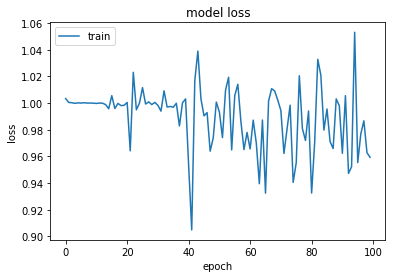

In [132]:
loss=h.history['loss']

plt.plot(loss, label='loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

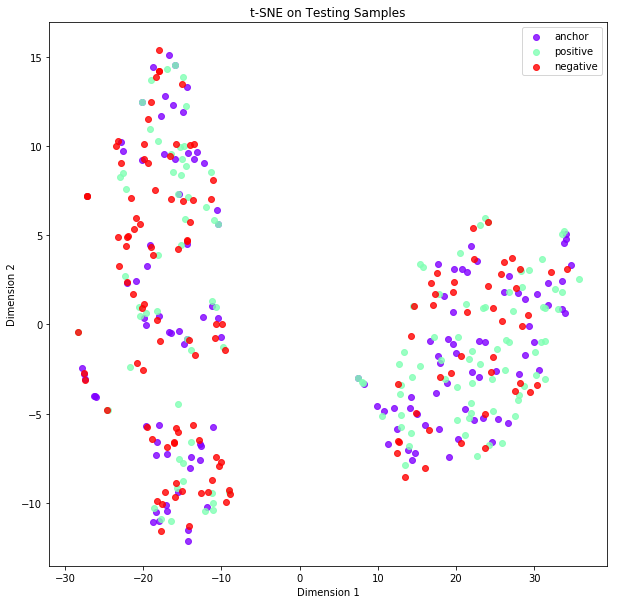

Wall time: 17 s


In [133]:
%%time

baseline.display_embed_space(similarity_model, 128)

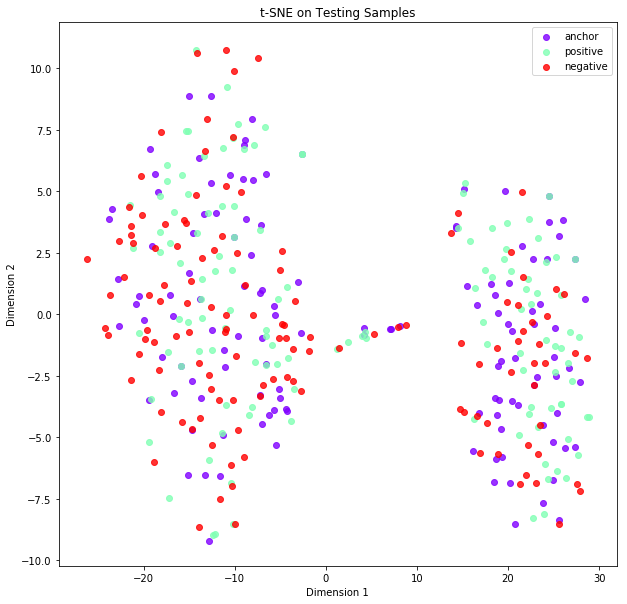

Wall time: 32.5 s


In [130]:
%%time

baseline.display_embed_space(similarity_model, 128)

In [ ]:
name = 'baseline_100epoch_16steps_(eclipse)'
Baseline.save_model('', similarity_model, name)
Baseline.save_result('', h, name)

In [ ]:
name = 'baseline_100epoch_16steps_(eclipse)'
Baseline.load_model('', name)

## Classification

In [ ]:
for layer in similarity_model.layers:
    print(layer.name)

In [ ]:
## Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False
    
# Model 1
model_in = similarity_model.get_layer('merge_features_in')
model_pos = similarity_model.get_layer('merge_features_pos')
x_in = model_in.output
x_pos = model_pos.output
x = Concatenate()([x_in, x_pos])
x = Dense(64, activation = 'relu')(x)
#x = Dense(32, activation = 'relu')(x)
output_1 = Dense(2, activation = 'softmax', name = 'output')(x)

# Model 2
model_in = similarity_model.get_layer('merge_features_in')
model_neg = similarity_model.get_layer('merge_features_neg')
x_in = model_in.output
x_neg = model_neg.output
x = Concatenate()([x_in, x_neg])
x = Dense(64, activation = 'relu')(x)
#x = Dense(32, activation = 'relu')(x)
output_2 = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=similarity_model.input, outputs=[output_1, output_2])
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model_clf.summary()

In [ ]:
%%time

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

valid_labels = encoder.fit_transform(test_gen[1])
valid_labels = to_categorical(valid_labels)
test_validation = (test_gen[0], valid_labels)

h_clf = model_clf.fit_generator(baseline.siam_gen_classification(bug_dir, 512, 1), 
                               steps_per_epoch = 16,
                               validation_data=test_validation, # 
                                             epochs = 100,
                                             verbose = True) # callbacks=[early]

In [ ]:
Baseline.validation_accuracy_loss(h_clf)

In [ ]:
name = 'baseline_classification_100epoch_16steps(eclipse)'
save_model(similarity_model, name)
save_result(h, name)